# 03 - Modelagem de Previsão de Demanda

Este notebook treina e avalia modelos de previsão (RandomForest e SARIMA).

RandomForest - RMSE: 122.93, MAE: 101.28, MAPE: 542.83%
SARIMA - RMSE: 131.46, MAE: 109.40, MAPE: 675.53%


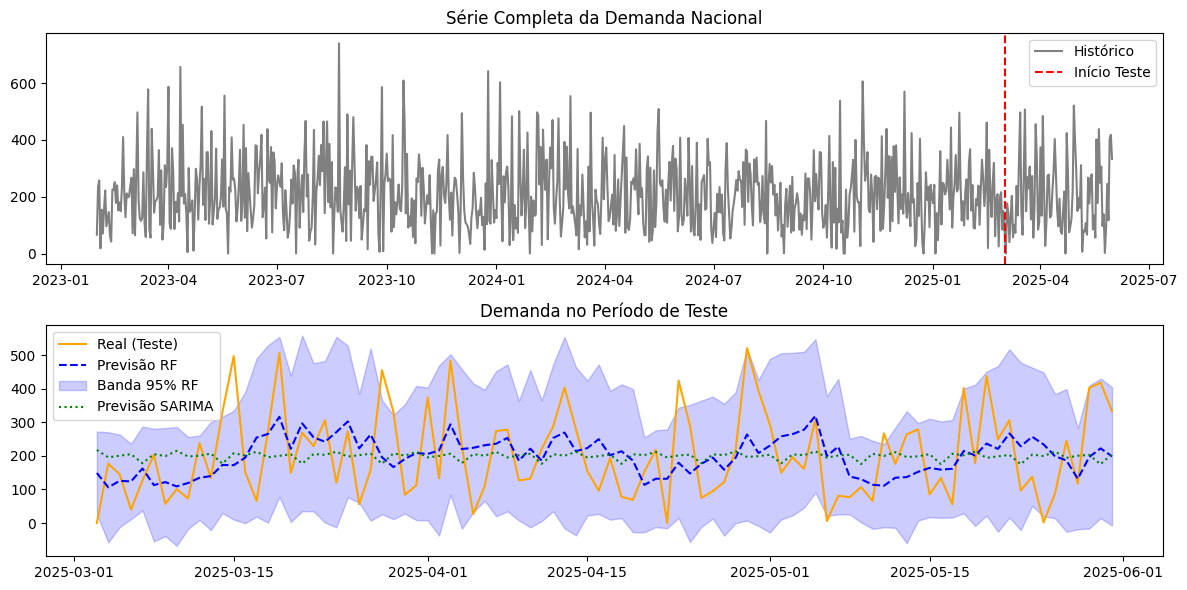

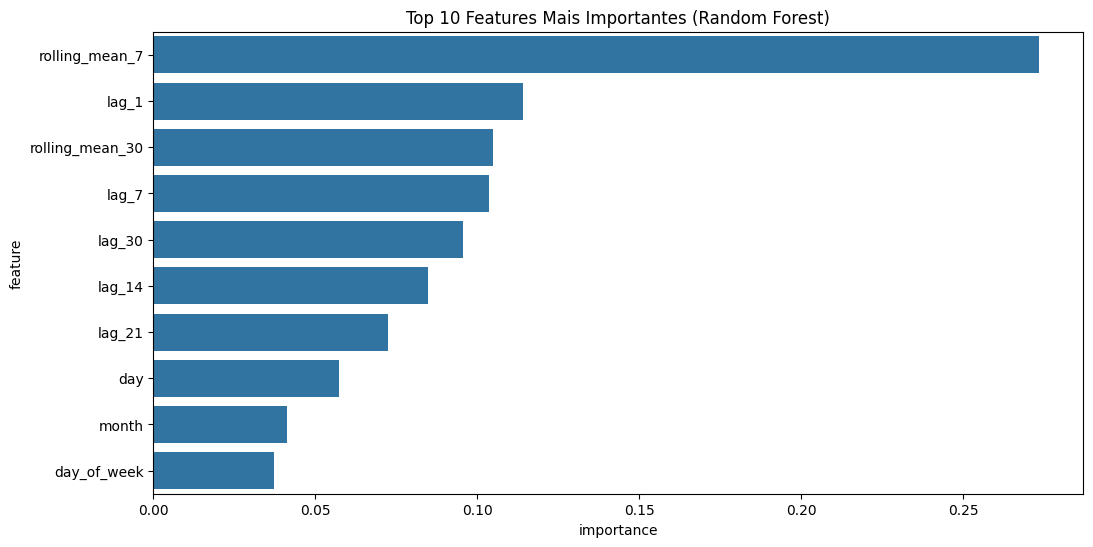

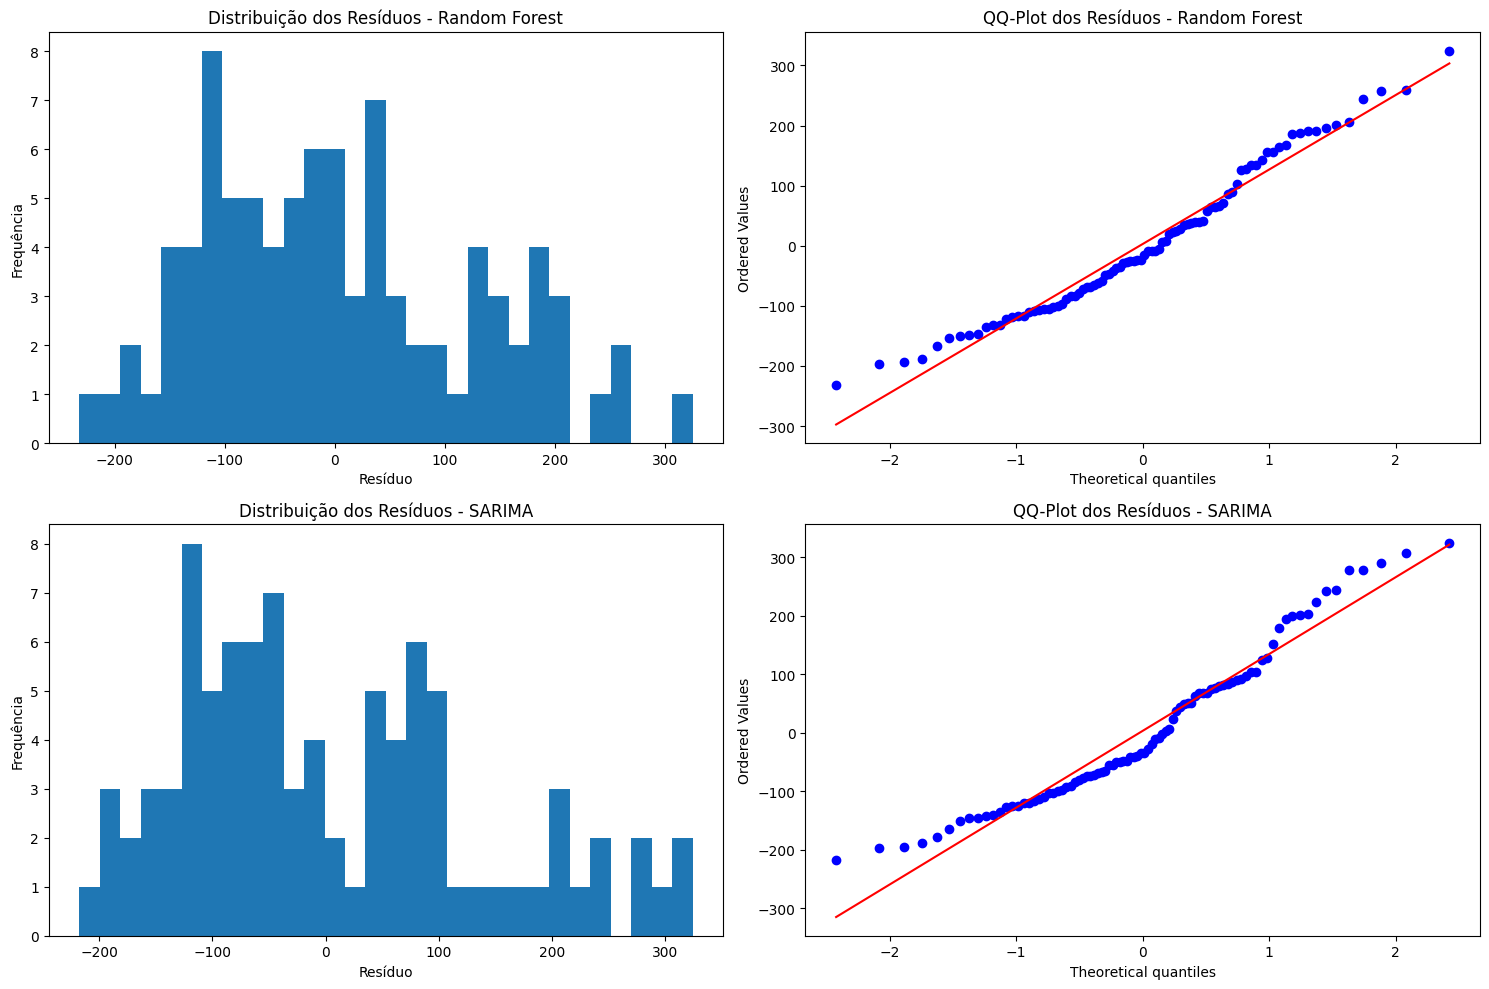


Resultados da Validação Cruzada Temporal (MAPE):
Random Forest - Média: 436.36%, Desvio Padrão: 181.67%
SARIMA - Média: 538.21%, Desvio Padrão: 285.14%


<Figure size 1200x600 with 0 Axes>

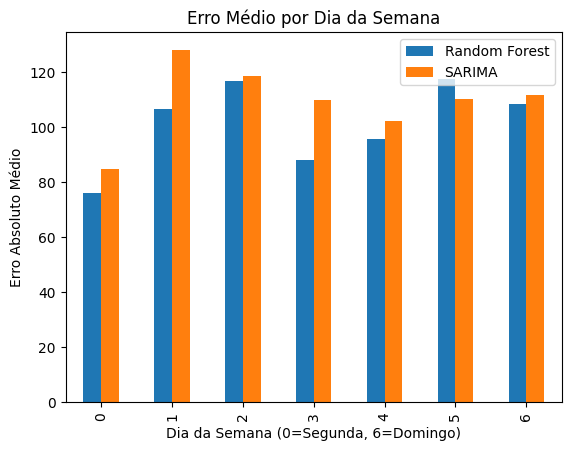

<Figure size 1200x600 with 0 Axes>

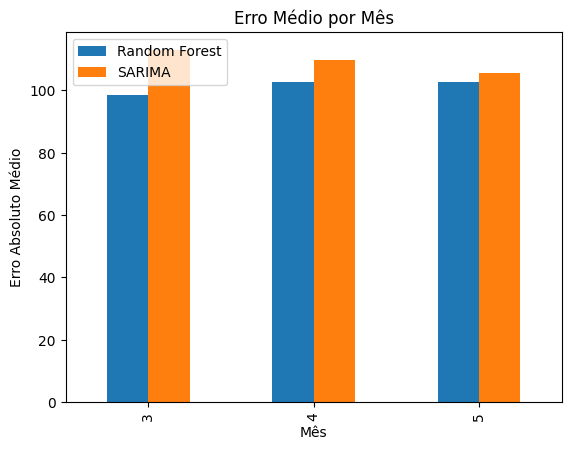

In [5]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import seaborn as sns

# Função útil para cálculo de MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

# Carregar dados processados
demanda_features = pd.read_csv("../data/processed/demanda_features.csv", parse_dates=["date"])
demanda_features = demanda_features.set_index("date")

# Garantir que o índice tem frequência diária
demanda_features = demanda_features.asfreq('D')

# Separar target e features
y = demanda_features["y"]
X = demanda_features.drop(columns=["y"])

# Dividir treino/teste (últimos 90 dias para teste)
num_test_days = 90
split_date = demanda_features.index.max() - pd.Timedelta(days=num_test_days)
X_train = X.loc[:split_date]
X_test = X.loc[split_date + pd.Timedelta(days=1):]
y_train = y.loc[:split_date]
y_test = y.loc[split_date + pd.Timedelta(days=1):]

# ----------------------------
# 1) RandomForest
# ----------------------------
# Converter para numpy arrays para evitar warnings de feature names
X_train_array = X_train.values
X_test_array = X_test.values

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train_array, y_train)

# Previsão RF e banda de confiança
all_preds = np.stack([tree.predict(X_test_array) for tree in rf.estimators_], axis=1)
pred_mean_rf = all_preds.mean(axis=1)
pred_std_rf = all_preds.std(axis=1)
lower_rf = pred_mean_rf - 1.96 * pred_std_rf
upper_rf = pred_mean_rf + 1.96 * pred_std_rf

# Métricas RF
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_mean_rf))
mae_rf = mean_absolute_error(y_test, pred_mean_rf)
mape_rf = mean_absolute_percentage_error(y_test, pred_mean_rf)
print(f"RandomForest - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, MAPE: {mape_rf:.2f}%")

# ----------------------------
# 2) SARIMA
# ----------------------------
# Garantir que os dados de treino têm frequência diária
y_train = y_train.asfreq('D')
X_train_eventos = X_train[["evento_na_data"]].asfreq('D')

model_sarima = SARIMAX(y_train, 
                      order=(1,1,1), 
                      seasonal_order=(1,1,1,7),
                      exog=X_train_eventos,
                      enforce_stationarity=False, 
                      enforce_invertibility=False)
fit_sarima = model_sarima.fit(disp=False)

# Garantir que os dados de teste têm frequência diária
X_test_eventos = X_test[["evento_na_data"]].asfreq('D')
pred_sarima = fit_sarima.predict(start=X_test.index[0], 
                               end=X_test.index[-1],
                               exog=X_test_eventos)

# Métricas SARIMA
rmse_sarima = np.sqrt(mean_squared_error(y_test, pred_sarima))
mae_sarima = mean_absolute_error(y_test, pred_sarima)
mape_sarima = mean_absolute_percentage_error(y_test, pred_sarima)
print(f"SARIMA - RMSE: {rmse_sarima:.2f}, MAE: {mae_sarima:.2f}, MAPE: {mape_sarima:.2f}%")

# ----------------------------
# 3) Plot comparativo
# ----------------------------
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

# Série completa
demanda_nacional = demanda_features["y"]
axs[0].plot(demanda_nacional.index, demanda_nacional.values, color='gray', label='Histórico')
axs[0].axvline(split_date, color='red', linestyle='--', label='Início Teste')
axs[0].set_title('Série Completa da Demanda Nacional')
axs[0].legend()

# Zoom no período de teste
axs[1].plot(y_test.index, y_test.values, color='orange', label='Real (Teste)')
axs[1].plot(y_test.index, pred_mean_rf, '--', color='blue', label='Previsão RF')
axs[1].fill_between(y_test.index, lower_rf, upper_rf, color='blue', alpha=0.2, label='Banda 95% RF')
axs[1].plot(y_test.index, pred_sarima, ':', color='green', label='Previsão SARIMA')
axs[1].set_title('Demanda no Período de Teste')
axs[1].legend()

plt.tight_layout()
plt.show()

# ----------------------------
# 4) Análise de Importância das Features
# ----------------------------
# Importância das features do Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features Mais Importantes (Random Forest)')
plt.show()

# ----------------------------
# 5) Análise de Resíduos
# ----------------------------
# Resíduos do Random Forest
residuos_rf = y_test - pred_mean_rf

# Resíduos do SARIMA
residuos_sarima = y_test - pred_sarima

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Histograma dos resíduos RF
axs[0,0].hist(residuos_rf, bins=30)
axs[0,0].set_title('Distribuição dos Resíduos - Random Forest')
axs[0,0].set_xlabel('Resíduo')
axs[0,0].set_ylabel('Frequência')

# QQ-Plot dos resíduos RF
stats.probplot(residuos_rf, dist="norm", plot=axs[0,1])
axs[0,1].set_title('QQ-Plot dos Resíduos - Random Forest')

# Histograma dos resíduos SARIMA
axs[1,0].hist(residuos_sarima, bins=30)
axs[1,0].set_title('Distribuição dos Resíduos - SARIMA')
axs[1,0].set_xlabel('Resíduo')
axs[1,0].set_ylabel('Frequência')

# QQ-Plot dos resíduos SARIMA
stats.probplot(residuos_sarima, dist="norm", plot=axs[1,1])
axs[1,1].set_title('QQ-Plot dos Resíduos - SARIMA')

plt.tight_layout()
plt.show()

# ----------------------------
# 6) Validação Cruzada Temporal
# ----------------------------
from sklearn.model_selection import TimeSeriesSplit

# Configurar validação cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Listas para armazenar métricas
rf_scores = []
sarima_scores = []

# Realizar validação cruzada
for train_idx, test_idx in tscv.split(X):
    X_train_cv = X.iloc[train_idx]
    X_test_cv = X.iloc[test_idx]
    y_train_cv = y.iloc[train_idx]
    y_test_cv = y.iloc[test_idx]
    
    # Treinar e avaliar Random Forest
    rf_cv = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
    rf_cv.fit(X_train_cv, y_train_cv)
    pred_rf_cv = rf_cv.predict(X_test_cv)
    mape_rf_cv = mean_absolute_percentage_error(y_test_cv, pred_rf_cv)
    rf_scores.append(mape_rf_cv)
    
    # Treinar e avaliar SARIMA
    model_sarima_cv = SARIMAX(y_train_cv, 
                             order=(1,1,1), 
                             seasonal_order=(1,1,1,7),
                             exog=X_train_cv[["evento_na_data"]],
                             enforce_stationarity=False, 
                             enforce_invertibility=False)
    fit_sarima_cv = model_sarima_cv.fit(disp=False)
    pred_sarima_cv = fit_sarima_cv.predict(start=X_test_cv.index[0], 
                                          end=X_test_cv.index[-1],
                                          exog=X_test_cv[["evento_na_data"]])
    mape_sarima_cv = mean_absolute_percentage_error(y_test_cv, pred_sarima_cv)
    sarima_scores.append(mape_sarima_cv)

print("\nResultados da Validação Cruzada Temporal (MAPE):")
print(f"Random Forest - Média: {np.mean(rf_scores):.2f}%, Desvio Padrão: {np.std(rf_scores):.2f}%")
print(f"SARIMA - Média: {np.mean(sarima_scores):.2f}%, Desvio Padrão: {np.std(sarima_scores):.2f}%")

# ----------------------------
# 7) Comparação Detalhada dos Modelos
# ----------------------------
# Criar DataFrame com resultados
resultados = pd.DataFrame({
    'Data': y_test.index,
    'Real': y_test.values,
    'RF': pred_mean_rf,
    'SARIMA': pred_sarima
})

# Calcular métricas por período
resultados['Erro_RF'] = np.abs(resultados['Real'] - resultados['RF'])
resultados['Erro_SARIMA'] = np.abs(resultados['Real'] - resultados['SARIMA'])

# Análise por dia da semana
resultados['Dia_Semana'] = resultados.index.dayofweek
erro_por_dia = resultados.groupby('Dia_Semana')[['Erro_RF', 'Erro_SARIMA']].mean()

plt.figure(figsize=(12, 6))
erro_por_dia.plot(kind='bar')
plt.title('Erro Médio por Dia da Semana')
plt.xlabel('Dia da Semana (0=Segunda, 6=Domingo)')
plt.ylabel('Erro Absoluto Médio')
plt.legend(['Random Forest', 'SARIMA'])
plt.show()

# Análise por mês
resultados['Mes'] = resultados.index.month
erro_por_mes = resultados.groupby('Mes')[['Erro_RF', 'Erro_SARIMA']].mean()

plt.figure(figsize=(12, 6))
erro_por_mes.plot(kind='bar')
plt.title('Erro Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Erro Absoluto Médio')
plt.legend(['Random Forest', 'SARIMA'])
plt.show()